# Plotting Resistivity and Siesmic Data

This notebook demonstrates how to extract a resistivity profile from a ModEM 3D volume, along a 2D seismic line, and plot both the resistivity and seismic data as overlays.

In [1]:
# Add mtpy folder to python path. This may not be necessary 
# depending on how mtpy was installed.
import sys

#sys.path.append('/path/to/mtpy')
sys.path.append('/media/data/work/GA/ausLAMP/codes/mtGeoMtpy/')

In [2]:
%%capture

# import modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import colors
# Import required classes from key mtpy modules 
from mtpy.imaging.seismic import Segy, VelocityModel
from mtpy.modeling.modem.plot_slices import PlotSlices

%matplotlib inline

## Load Data

In [3]:
%%capture
# The Segy class is used to load 2D segy data
# The VelocityModel class is used to create a velocity model based on stacking velocities
segy_fn = '../data/seismic/seismic.sgy'
stacking_velocity_fn = '../data/seismic/stacking_velocities.txt'
m_fn = '../data/ModEM_files/Modular_MPI_NLCG_056_im2.rho'
d_fn = '../data/ModEM_files/ModEM_Data_im2.dat'

# load segy data
sl = Segy(segy_fn)

# instantiate velocity model; for a constant velocity, set vm = 6000 (m/s)
vm = VelocityModel(stacking_velocity_fn, ni=20) 

# instantiate PlotSlices class; note that we want coordinates in metres, as in the seismic line
ps = PlotSlices(model_fn=m_fn, data_fn=d_fn, plot_yn='n', map_scale='m')

## Fetch Migrated Seismic Profile and Resistivity Profile Along Seismic Line

Concentration of traces, as a function of distance from the start of the 2D line, may vary, which can lead to plotting artefacts. To avoid such artefacts, we fetch traces at regular intervals along the length of the survey.

In [4]:
%%capture

# fetch a depth-migrated image (done using velocity model defined earlier)
mdepth, mdist, svals, xy_list = sl.getMigratedProfile(vm, time_shift=225, nn=1)

# fetch resistivity along seismic line
gd, gz, mvals = ps.get_slice(option='XY', coords=xy_list, nn=1, absolute_query_locations=True)

## Plot Both Profiles

/home/rakib/.local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


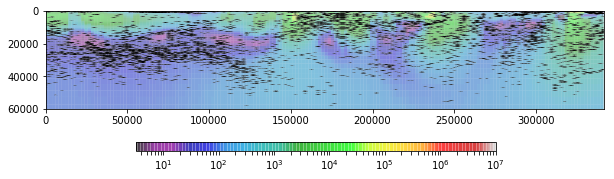

In [5]:
# set plot dimensions
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
fig,ax = plt.subplots(1,1)

# plot resistivity ==================================================
ci = ax.pcolor(gd, gz, mvals, 
               norm=colors.LogNorm(),
               vmin=np.power(10,0.5), vmax=np.power(10,7),
               cmap='nipy_spectral', 
               alpha=0.5, linewidth=0, 
               edgecolors='None',
               rasterized=True)

# deal with white stripes
ci.set_antialiaseds(True)
ci.set_rasterized(True)

# plot colorbar.
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.025])
cb = plt.colorbar(ci, cax=cb_ax, ticks = LogLocator(subs=range(10)), 
                  orientation="horizontal")
cb.solids.set_edgecolor('none') 
cb.solids.set_antialiased(True)
cb.solids.set_rasterized(True) 


# set max depth to 60 km, because the resistivity model goes much deeper
M_MAX_DEPTH = 60e3

# Plot seismic ======================================================   
# compute the 99th percentile and zero out all values below that. This can
# be tweaked to plot the required amount of detail without cluttering the
# plot


vmm = np.percentile(svals.flatten(), 99) 
svalsClipped = np.array(svals)
svalsClipped[svalsClipped<vmm]=0
ci = ax.contourf(mdist, mdepth, svalsClipped, 50, 
                 vmin=-vmm, vmax=vmm,
                 cmap='Greys', alpha=0.15, rasterized=True)
    
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_ylim(M_MAX_DEPTH) 


plt.savefig('/tmp/c.png', dpi=600)